In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
 
# 1. 加载数据并预处理
iris = load_iris()
X = iris.data[:, [2, 3]]  # 特征选择length和width
y = iris.target
X

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

Training accuracy: 0.8667
Validation accuracy: 0.7000
Test accuracy: 0.8333


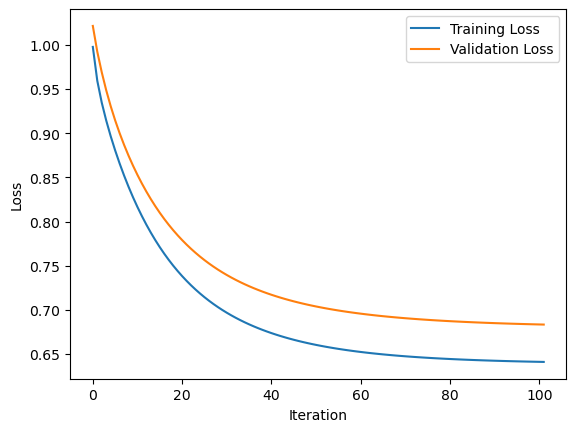

In [9]:
# 将数据分为训练集、验证集和测试集 (60%-20%-20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
 
# 2. Softmax回归实现
class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, reg_strength=0.1, max_iter=1000, 
                 early_stop_patience=10, tol=1e-4, random_state=None):
        self.learning_rate = learning_rate # 学习率
        self.reg_strength = reg_strength  # L2正则化系数
        self.max_iter = max_iter
        self.early_stop_patience = early_stop_patience # 早停耐心值
        self.tol = tol  # 收敛阈值
        self.random_state = random_state
        self.theta = None
        self.loss_history = []
        self.val_loss_history = []
        
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def _compute_loss(self, X, y):
        m = X.shape[0]
        probs = self._softmax(X.dot(self.theta.T))
        
        data_loss = np.sum(-np.log(probs[range(m), y])) / m
        reg_loss = 0.5 * self.reg_strength * np.sum(np.square(self.theta[:, 1:]))  # 正则化项
        return data_loss + reg_loss
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_classes = len(np.unique(y)) # 类别数量
        n_features = X.shape[1] # 特征数量
        
        # 将标签转换为one-hot编码
        y_onehot = np.zeros((len(y), n_classes))
        y_onehot[np.arange(len(y)), y] = 1
        
        self.theta = np.random.randn(n_classes, n_features) * 0.01
        
        best_val_loss = np.inf
        patience_count = 0
        
        for i in range(self.max_iter):
            probs = self._softmax(X.dot(self.theta.T))
            grad = (probs - y_onehot).T.dot(X) / X.shape[0]
            grad[:, 1:] += self.reg_strength * self.theta[:, 1:]
            
            self.theta -= self.learning_rate * grad # 参数更新
            train_loss = self._compute_loss(X, y)
            self.loss_history.append(train_loss) # 记录损失
            
            # 如果有验证集，计算验证损失
            if X_val is not None and y_val is not None:
                val_loss = self._compute_loss(X_val, y_val)
                self.val_loss_history.append(val_loss)
                # 早停机制
                if val_loss + self.tol < best_val_loss: # 模型参数提升大于阈值
                    best_val_loss = val_loss
                    patience_count = 0 # 重置耐心计数
                    best_theta = self.theta.copy()
                else:
                    patience_count += 1
                    if patience_count >= self.early_stop_patience: # 耐心次数后无优化效果,结束训练
                        self.theta = best_theta
                        break
            # 检查收敛
            if i > 0 and abs(self.loss_history[-2] - train_loss) < self.tol:
                break
        return self
    
    def predict_proba(self, X):
        """预测概率"""
        return self._softmax(X.dot(self.theta.T))
    
    def predict(self, X):
        """预测类别"""
        return np.argmax(self.predict_proba(X), axis=1)
    
    def score(self, X, y):
        """计算准确率"""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
 
# 3. 训练和评估模型
model = SoftmaxRegression(learning_rate=0.1, reg_strength=0.1, max_iter=1000, 
                         early_stop_patience=10, random_state=42)
model.fit(X_train, y_train, X_val, y_val)
 
# 4. 评估模型
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
test_acc = model.score(X_test, y_test)
 
print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
 
# 5. 可视化损失曲线
import matplotlib.pyplot as plt
 
plt.plot(model.loss_history, label='Training Loss')
if hasattr(model, 'val_loss_history') and model.val_loss_history:
    plt.plot(model.val_loss_history, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()